Test out a custom trainer that takes class weights into account

In [1]:
import pandas as pd
import os
import time
from typing import List

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForSequenceClassification
import torch

from transformers import TrainingArguments, Trainer

import evaluate


from sklearn.utils.class_weight import compute_class_weight

import hyperopt

from torch import nn
from transformers import Trainer


/home/losullivan/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-27 11:58:28.025117: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-27 11:58:28.025157: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-27 11:58:28.025192: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-27 11:58:28.032128: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary 

In [2]:
# Senolytic dataset - labelled
senolytics_df = pd.read_csv('list_of_compounds_for_training.csv')
senolytics_df

,Name,senolytic,Library,Source,SMILES,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,qed
0,Azaguanine-8,0,Prestwick,Not identified,c12/N=C(\NC(c1nn[nH]2)=O)/N,3.024307,441.024163,7.844935,5.327239,5.327239,...,0,0,0,0,0,0,0,0,0,0.430316
1,Allantoin,0,Prestwick,Not identified,N1C(NC(C1=O)NC(=O)N)=O,2.534439,225.377060,8.430721,5.379445,5.379445,...,0,0,0,0,0,0,0,0,2,0.325138
2,Acetazolamide,0,Prestwick,Not identified,c1(S(=O)(=O)N)sc(nn1)NC(=O)C,2.938691,422.352468,10.060478,6.513019,8.146012,...,1,0,0,0,0,0,0,0,0,0.631859
3,Metformin hydrochloride,0,Prestwick,Not identified,C(NC(=N)N)(=N)N(C)C,3.644486,126.919685,7.439158,5.524564,5.524564,...,0,0,0,0,0,0,0,0,0,0.248785
4,Atracurium besylate,0,Prestwick,Not identified,[N+]1(C(c2c(cc(c(c2)OC)OC)CC1)Cc1cc(c(cc1)OC)O...,0.987040,2158.836594,48.141042,41.328212,41.328212,...,0,0,0,0,0,0,0,4,0,0.038349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2518,Curcumin,1,"GPNCL, ENZO","Source 12 - Yousefzadeh et al, 2018",COC1=C(C=CC(=C1)/C=C/C(=O)CC(=O)/C=C/C2=CC(=C(...,1.958861,822.040000,19.811190,15.008030,15.008030,...,0,0,0,0,0,0,0,0,0,0.548123
2519,Dasatinib,1,"Unknown library, see publication source","Source 13 - Zhu et al, 2015",CC1=C(C(=CC=C1)Cl)NC(=O)C2=CN=C(S2)NC3=CC(=NC(...,1.431593,1111.432171,23.371668,18.507135,20.079560,...,0,0,0,0,1,0,0,0,0,0.465717
2520,Navitoclax,1,"Unknown library, see publication source","Source 14 - Zhu et al, 2016",CC1(CCC(=C(C1)CN2CCN(CC2)C3=CC=C(C=C3)C(=O)NS(...,1.017180,2532.551918,46.408991,36.449290,39.654708,...,1,1,0,0,0,0,0,0,0,0.104649
2521,A1331852,1,"Unknown library, see publication source","Source 15 - Zhu et al, 2017",O=C(NC1=NC(C=CC=C2)=C2S1)C3=C(CN(C4=CC=C(C5=C(...,0.969918,2030.733706,32.569974,26.984648,27.801144,...,0,0,0,0,1,0,0,0,0,0.185260


In [3]:
training_df = senolytics_df[['SMILES', 'senolytic']]
training_df

,SMILES,senolytic
0,c12/N=C(\NC(c1nn[nH]2)=O)/N,0
1,N1C(NC(C1=O)NC(=O)N)=O,0
2,c1(S(=O)(=O)N)sc(nn1)NC(=O)C,0
3,C(NC(=N)N)(=N)N(C)C,0
4,[N+]1(C(c2c(cc(c(c2)OC)OC)CC1)Cc1cc(c(cc1)OC)O...,0
...,...,...
2518,COC1=C(C=CC(=C1)/C=C/C(=O)CC(=O)/C=C/C2=CC(=C(...,1
2519,CC1=C(C(=CC=C1)Cl)NC(=O)C2=CN=C(S2)NC3=CC(=NC(...,1
2520,CC1(CCC(=C(C1)CN2CCN(CC2)C3=CC=C(C=C3)C(=O)NS(...,1
2521,O=C(NC1=NC(C=CC=C2)=C2S1)C3=C(CN(C4=CC=C(C5=C(...,1


In [4]:
# # Subset for testing new code

#training_df =  training_df.groupby('senolytic', group_keys=False).apply(lambda x: x.sample(frac=0.1))
#training_df



In [5]:
# Check sample is representative of the actual distribution
sum(training_df['senolytic'])/len(training_df)

0.022988505747126436

In [6]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("ncfrey/ChemGPT-4.7M")
model = AutoModelForCausalLM.from_pretrained("ncfrey/ChemGPT-4.7M")

In [7]:
# Use a pipeline as a high-level helper
from transformers import pipeline
smiles_string = training_df['SMILES'][9]
print(smiles_string)

pipe = pipeline("text-generation", model="ncfrey/ChemGPT-4.7M")

pipe(smiles_string)


S1(c2cc(S(=O)(=O)N)c(cc2CCC1)C)(=O)=O


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'S1(c2cc(S(=O)(=O)N)c(cc2CCC1)C)(=O)=O[C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C] [C

## Finetune
https://huggingface.co/docs/transformers/training

In [8]:
tokenizer = AutoTokenizer.from_pretrained("ncfrey/ChemGPT-4.7M", pad_token="[PAD]")
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))


config = AutoConfig.from_pretrained("ncfrey/ChemGPT-4.7M")
config.num_hidden_layers += 1
model = AutoModelForSequenceClassification.from_pretrained("ncfrey/ChemGPT-4.7M", num_labels=2, problem_type = "single_label_classification")
model.config.pad_token_id = tokenizer.pad_token_id

print(f"Model size: {model.num_parameters()} parameters.")



Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at ncfrey/ChemGPT-4.7M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model size: 5099520 parameters.


In [9]:
from sklearn.model_selection import train_test_split
X = training_df[['SMILES']]
y = training_df['senolytic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # the data should be shuffled


In [10]:
# Dataset set up

#smiles_train = X_train['SMILES'].astype(str).tolist()
#smiles_test = X_test['SMILES'].astype(str).tolist()


In [11]:
# # https://huggingface.co/transformers/v3.2.0/custom_datasets.html -> does not work!!
# from transformers import AutoTokenizer, AutoModel
# import torch


# class SenolyticsDataset(torch.utils.data.Dataset):
#     def __init__(self, encodings, labels):
#         self.encodings = encodings
#         self.labels = labels

#     def __getitem__(self, idx):
#         #print(idx)
#         input_ids = torch.tensor(self.encodings['input_ids'])
#         if self.labels is not None and idx in self.labels.keys():
#             target_ids = torch.tensor(self.labels[idx])
#         else:
#             # Handle the case where self.labels is None or idx is out of range
#             target_ids = None
#         return {"input_ids": input_ids, "labels": target_ids}

#     def __len__(self):
#         return len(self.labels)
# #train_dataset = IMDbDataset(train_encodings, train_labels)
# #val_dataset = IMDbDataset(val_encodings, val_labels)
# #test_dataset = IMDbDataset(test_encodings, test_labels)

# tokenized_train = tokenizer(smiles_train, padding=True, truncation=True, max_length=None, return_tensors='pt')
# tokenized_test = tokenizer(smiles_test, padding=True, truncation=True, max_length=None, return_tensors='pt')

# train_dataset = SenolyticsDataset(tokenized_train, y_train)
# test_dataset = SenolyticsDataset(tokenized_test, y_test)


In [12]:
import torch

#Current version
class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, labels, tokenizer):
        self.dataframe = dataframe
        self.tokenizer = tokenizer

        # Tokenize the SMILES strings and store them
        self.encodings = self.tokenize_smiles(dataframe['SMILES'].tolist())

        # Store the labels
        self.labels = labels.tolist()


    def tokenize_smiles(self, smiles_list):
        return self.tokenizer(
            smiles_list,
            truncation=False,
            padding=True,
            max_length=None,
            return_tensors='pt'
        )

    def __getitem__(self, idx):
        item = {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }
        return item

    def __len__(self):
        return len(self.labels)


In [13]:
train_dataset = Dataset(X_train, y_train, tokenizer)
test_dataset = Dataset(X_test, y_test, tokenizer)

In [14]:
type(train_dataset[-1]['input_ids'])

torch.Tensor

In [15]:


metric = evaluate.load("f1")

In [16]:
# https://stackoverflow.com/questions/67457480/how-to-get-the-accuracy-per-epoch-or-step-for-the-huggingface-transformers-train

def compute_metrics(eval_pred):
    metrics = ["accuracy", "recall", "precision", "f1"] #List of metrics to return
    metric={}
    for met in metrics:
       metric[met] = evaluate.load(met)
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    metric_res={}
    for met in metrics:
       metric_res[met]=metric[met].compute(predictions=predictions, references=labels)[met]
    return metric_res

In [17]:
# Class weights




class_weights = compute_class_weight(class_weight="balanced",classes=np.unique(y_train),y=y_train)


print(class_weights)

[ 0.51188406 21.53658537]


In [18]:
# https://huggingface.co/docs/transformers/main/main_classes/trainer




class CustomTrainer(Trainer):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels").long()
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss with class_weights=balanced from above
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, device=model.device, dtype=torch.float))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [19]:
X = training_df[['SMILES']]
y = training_df['senolytic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

train_dataset = Dataset(X_train, y_train, tokenizer)
test_dataset = Dataset(X_test, y_test, tokenizer)


In [20]:
# Just loading chemberta's best just to have something to work with and this code was already in the notebook

f = open("best_trial_100.txt", "r")
print(f.read())

{"best_value": 0.8544822926882423, "best_params": {"learning_rate": 0.00023738342619168549, "weight_decay": 0.0012279807479264777, "num_train_epochs": 10, "warmup_ratio": 0.2997009188502863}, "best_trial_number": 86}


In [21]:
import json

with open("best_trial_100_chemGPT_1.txt", "r") as fp:
    best_trial_dict = json.load(fp)


print(best_trial_dict['best_params'])
best_params = best_trial_dict['best_params']

{'learning_rate': 0.0002822312812361537, 'weight_decay': 5.0796095265955036e-05, 'num_train_epochs': 10}


In [23]:
from transformers import TrainingArguments, Trainer

# many more parameters to experiment with https://huggingface.co/docs/transformers/v4.33.2/en/main_classes/trainer#transformers.TrainingArguments
training_args = TrainingArguments(output_dir="test_2", load_best_model_at_end=True, evaluation_strategy='epoch',
    logging_strategy="epoch", save_strategy="epoch",per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,optim="adamw_torch", num_train_epochs=best_params['num_train_epochs'], learning_rate=best_params['learning_rate'],
                                  weight_decay=best_params['weight_decay']) # switch optimizer to avoid warning)


In [24]:
from transformers import TrainerCallback
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Define a callback for printing validation loss
class PrintValidationLossCallback(TrainerCallback):
    def on_evaluate(self, args, state, control, **kwargs):
        if state is not None and hasattr(state, 'eval_loss'):
            print(f"Validation loss: {state.eval_loss:.4f}")

# Add the callback to the trainer
trainer.add_callback(PrintValidationLossCallback())
#trainer.train()

In [25]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,0.972100,1.953658,0.977543,0.000000,0.000000,0.000000
2,1.123700,1.515244,0.977543,0.000000,0.000000,0.000000
3,1.016200,2.041103,0.977543,0.000000,0.000000,0.000000
4,1.035000,1.809806,0.977543,0.000000,0.000000,0.000000
5,0.960200,1.999508,0.977543,0.000000,0.000000,0.000000
6,1.041700,1.688586,0.977543,0.000000,0.000000,0.000000
7,1.014900,1.824326,0.977543,0.000000,0.000000,0.000000
8,0.986100,1.699775,0.977543,0.000000,0.000000,0.000000
9,0.940800,1.601577,0.977543,0.000000,0.000000,0.000000
10,0.913000,1.808210,0.977543,0.000000,0.000000,0.000000


/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:

TrainOutput(global_step=1110, training_loss=1.0003696544750316, metrics={'train_runtime': 99.7495, 'train_samples_per_second': 177.044, 'train_steps_per_second': 11.128, 'total_flos': 29190898360320.0, 'train_loss': 1.0003696544750316, 'epoch': 10.0})

In [26]:
# Save the model
trainer.save_model("./full_model_chemGPT_experiment1")

In [27]:
model.eval()

GPTNeoForSequenceClassification(
  (transformer): GPTNeoModel(
    (wte): Embedding(684, 128)
    (wpe): Embedding(2048, 128)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPTNeoBlock(
        (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=128, out_features=128, bias=False)
            (v_proj): Linear(in_features=128, out_features=128, bias=False)
            (q_proj): Linear(in_features=128, out_features=128, bias=False)
            (out_proj): Linear(in_features=128, out_features=128, bias=True)
          )
        )
        (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=128, out_features=512, bias=True)
          (c_proj): L

In [28]:
predictions = trainer.predict(test_dataset)

/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
predictions.predictions

array([[ 2.1793094, -1.3867288],
       [ 2.1793094, -1.3867288],
       [ 2.151001 , -1.374819 ],
       ...,
       [ 2.1280537, -1.3537277],
       [ 2.1793094, -1.3867288],
       [ 2.1793094, -1.3867288]], dtype=float32)

In [30]:
trainer.evaluate()

/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.5152441263198853,
 'eval_accuracy': 0.9775429326287979,
 'eval_recall': 0.0,
 'eval_precision': 0.0,
 'eval_f1': 0.0,
 'eval_runtime': 3.9841,
 'eval_samples_per_second': 190.008,
 'eval_steps_per_second': 3.012,
 'epoch': 10.0}

In [31]:
y_pred = np.argmax(predictions.predictions, axis=-1)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [32]:
y_test.sum()

17

In [33]:
# senolytics predicted
y_pred.sum()

0

In [34]:
trainer.state.log_history



[{'loss': 0.9721,
  'learning_rate': 0.00025400815311253834,
  'epoch': 1.0,
  'step': 111},
 {'eval_loss': 1.9536577463150024,
  'eval_accuracy': 0.9775429326287979,
  'eval_recall': 0.0,
  'eval_precision': 0.0,
  'eval_f1': 0.0,
  'eval_runtime': 3.925,
  'eval_samples_per_second': 192.865,
  'eval_steps_per_second': 3.057,
  'epoch': 1.0,
  'step': 111},
 {'loss': 1.1237,
  'learning_rate': 0.00022578502498892298,
  'epoch': 2.0,
  'step': 222},
 {'eval_loss': 1.5152441263198853,
  'eval_accuracy': 0.9775429326287979,
  'eval_recall': 0.0,
  'eval_precision': 0.0,
  'eval_f1': 0.0,
  'eval_runtime': 4.1951,
  'eval_samples_per_second': 180.449,
  'eval_steps_per_second': 2.86,
  'epoch': 2.0,
  'step': 222},
 {'loss': 1.0162,
  'learning_rate': 0.00019756189686530757,
  'epoch': 3.0,
  'step': 333},
 {'eval_loss': 2.0411031246185303,
  'eval_accuracy': 0.9775429326287979,
  'eval_recall': 0.0,
  'eval_precision': 0.0,
  'eval_f1': 0.0,
  'eval_runtime': 4.1865,
  'eval_samples_per_

In [35]:
training_losses = [element['loss'] for element in trainer.state.log_history if 'loss' in element.keys()]
val_losses = [element['eval_loss'] for element in trainer.state.log_history if 'eval_loss' in element.keys()]

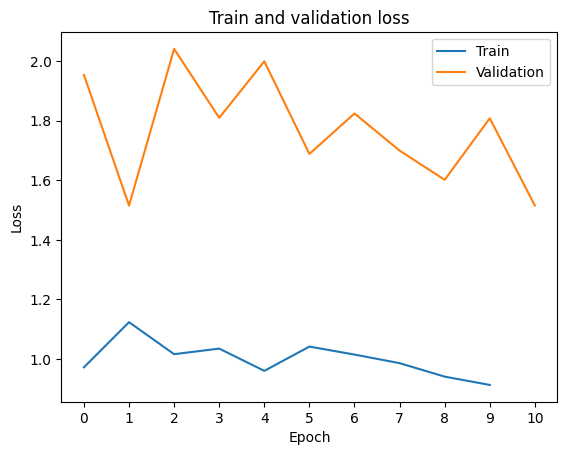

In [36]:
plt.plot(training_losses)
plt.plot(val_losses)
plt.title("Train and validation loss")
plt.xlabel("Epoch")
plt.ylabel('Loss')
plt.xticks([i for i in range(0,len(val_losses))])
plt.legend(['Train', 'Validation'])
plt.show()

Accuracy: 0.9775429326287979
Precision: 0.0
Recall: 0.0
F1: 0.0




/home/losullivan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


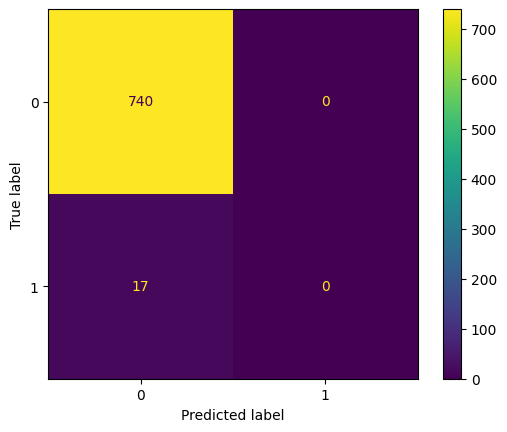

In [37]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
    ConfusionMatrixDisplay,
)


print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))


print("\n")
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)


disp.plot()

plt.show()




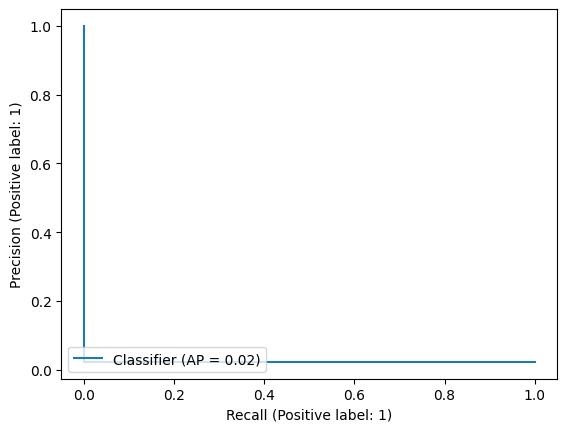

In [38]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html
from sklearn.metrics import (precision_recall_curve,
                              PrecisionRecallDisplay)

disp = PrecisionRecallDisplay.from_predictions(y_test, y_pred)
plt.show()



In [39]:
# https://stackoverflow.com/questions/67432457/python-get-the-index-of-two-list-where-the-values-are-the-same
print([i for i, v in enumerate(list(y_pred)) if v == list(y_test)[i] and v==1])

[]


In [40]:
#X_test.iloc[213]

In [41]:
#where they equal
correct_predictions_indices = [i for i, v in enumerate(list(y_pred)) if v == list(y_test)[i] and v==1]

for prediction_index in correct_predictions_indices:
    print(senolytics_df.loc[X_test.iloc[[prediction_index]].index[0]]['Name'])